In [1]:
library(doParallel)
library(R.matlab)
library(ggplot2)
library(fda)
library(caTools)
library(repr)

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
R.matlab v3.6.1 (2016-10-19) successfully loaded. See ?R.matlab for help.

Attaching package: ‘R.matlab’

The following objects are masked from ‘package:base’:

    getOption, isOpen

Loading required package: splines
Loading required package: Matrix

Attaching package: ‘fda’

The following object is masked from ‘package:graphics’:

    matplot



In [2]:
# Change plot size to 5 x 4
options(repr.plot.width=5, repr.plot.height=4)

In [3]:
# Read in pre_pmcao data
data = readMat('../F141020-lfp-5min-1kHz.mat')
pre_pmcao = data$pre.pmcao

In [4]:
CrossPowerSpectrum2 = function(X, T, m, factor=1){
  ### X: time series by COLUMNs, T: time, m: window smoothing.
  ##factor: PCA component return.
  #h = 1/(2*m + 1) ##uniform weight
  n = dim(X)[2]
  x.omega = matrix(0,n,T)
  
  for(i in 1:n){
    #x.omega[i,] = (1/sqrt(T))*fft(X[,i]);
    x.omega[i,] = fft(X[,i]);
  } 
  
  paddingSpectrum = array(0, dim = c(n,n,T+2*m))
  for(i in 1:(T/2) ){
    paddingSpectrum[,,(1+m):(T+m)] = x.omega[,i+1]%*%t(Conj(x.omega[,i+1]))
  }
  for(i in 1:m){
    paddingSpectrum[,,m+1-i] = Conj(paddingSpectrum[,,i+m+1])
    paddingSpectrum[,,T+m-i] = Conj(paddingSpectrum[,,i+T+m])
  }
  #Smoothing
  Sxx = array(0, dim=c(n,n,T/2))
  for(i in 1:(T/2)){
    Sxx[,,i] = apply(paddingSpectrum[,,(m+i-m):(m+i+m)],1:2,mean)
  }
  
  
  ##Store only store 1st component
  EigenValues = matrix(0,(T),1)
  EigenVectors = matrix(0,(T),n)
  for (k in 1:(T/2)) {
    u = eigen(Sxx[,,k], symmetric=TRUE)
    EigenValues[k,1] = u$values[factor]
    EigenVectors[k,] = u$vectors[,factor]
  }
  return(list(x.omega=x.omega,EigenValues=EigenValues,EigenVectors=EigenVectors))
}

ComputeFactors = function(x.omega, EigenValues, EigenVectors){
  n = dim(x.omega)[1]
  c.omega  = matrix(0,T,n)
  for(i in 1:(T/2)){
    c.omega[i,] = EigenVectors[i,]
  }
  for(i in (T/2+1):(T)){
    c.omega[i,] = Conj(c.omega[T-i+1,])
  }
  y=NULL
  for(i in 1:(T)){
    y = c(y, Conj(c.omega[T-i+1,])%*%(x.omega[,i]))
  }
  
  Y = fft(y,inverse=TRUE)/(T)
  
  return(Y)
}

In [5]:
excludes = c(1:5, 7:8, 11:12, 14:16, 18:26, 28:32)

In [8]:
i = 1
T = 1000
epoch1 = pre_pmcao[((i-1)*1000+1):(i*1000), excludes]
temp = CrossPowerSpectrum2(epoch1, T, m = 64,factor = 1)
epoch1_factor_1 = Re(ComputeFactors(temp$x.omega,temp$EigenValues,temp$EigenVectors))

In [9]:
# Read factors for SPCA
factor1_normalized_removed = as.matrix(read.csv("data/factor1_pre_normalized_removed.csv"))[, 2:1001]
factor2_normalized_removed = as.matrix(read.csv("data/factor2_pre_normalized_removed.csv"))[, 2:1001]

In [10]:
# Collect log periodograms of factors for each epoch
spca_log_periodograms <- function(factors) {
    log_list_removed = list()
    for (i in 1:300) {
        factor_epoch = factors[i,]
        periodogram = (abs(fft(factor_epoch)))^2
        log_pd = log(periodogram[1:500])
        log_list_removed[[i]] = log_pd
    }
    return (log_list_removed)
}

# Smooth the log periodograms
smoothing <- function(log_pds, w=11) {
    sm_log_pd_list = list()
    for(i in 1:300) {
        sm_log_pd = stats::filter(log_pds[[i]], rep(1/w, w), circular=TRUE)
        sm_log_pd_list[[i]] = sm_log_pd
    }
    return (sm_log_pd_list)
}

In [11]:
# Factor 1
spca_log_pds = spca_log_periodograms(factor1_normalized_removed)
smoothed_logperios = smoothing(spca_log_pds)
length(smoothed_logperios)

[1] 300

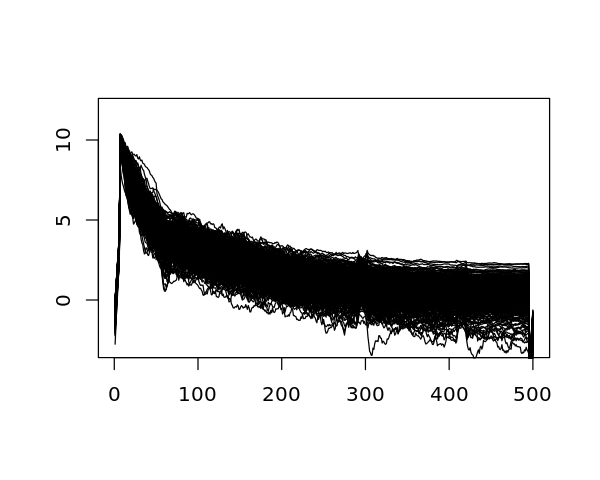

In [12]:
plot(smoothed_logperios[[1]], ylab="",xlab="", type="l", ylim=c(-3,12))
for (i in 2:length(smoothed_logperios)) {
    lines(smoothed_logperios[[i]])
}

In [13]:
# Create matrix of smooth log periodograms where ROWs are the different series
n = length(smoothed_logperios[[1]])
Xsp = matrix(unlist(smoothed_logperios), ncol=n, byrow=TRUE)
dim(Xsp)

[1] 300 500

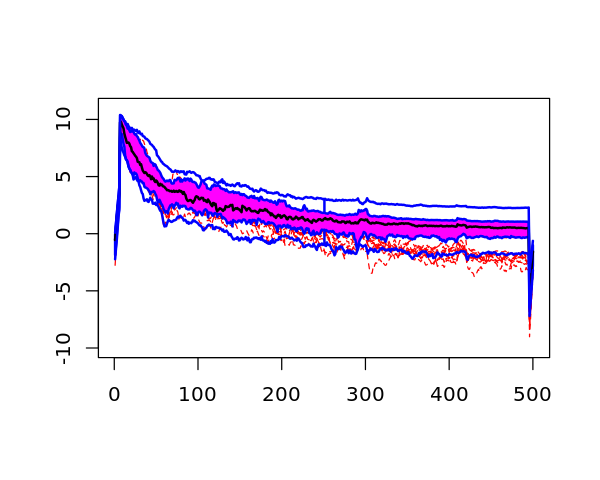

In [14]:
# Functional Box plot
t.grp1=fbplot(t(Xsp),method='MBD',ylab="",xlab="", ylim=c(-10, 11))